<a href="https://colab.research.google.com/github/Abhi-nand-shaji/Vehicle_Sound_Classification/blob/main/Vehicle_Sound_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vehicle Sound Classification**

**Context:**
This dataset was completely made manually by extracting audio from sources available on internet sites like Google and Youtube and saved as .wav audio format.

**Content:**
The dataset consists of wav-format audio files of different sounds such as siren sounds of  Ambulance, Traffics, Engine Revving and Firetruck.

In [1]:
!pip install librosa

In [2]:
import librosa
import librosa.display
from scipy import signal

import IPython.display as ipd

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import pickle

import pandas as pd

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D

import os

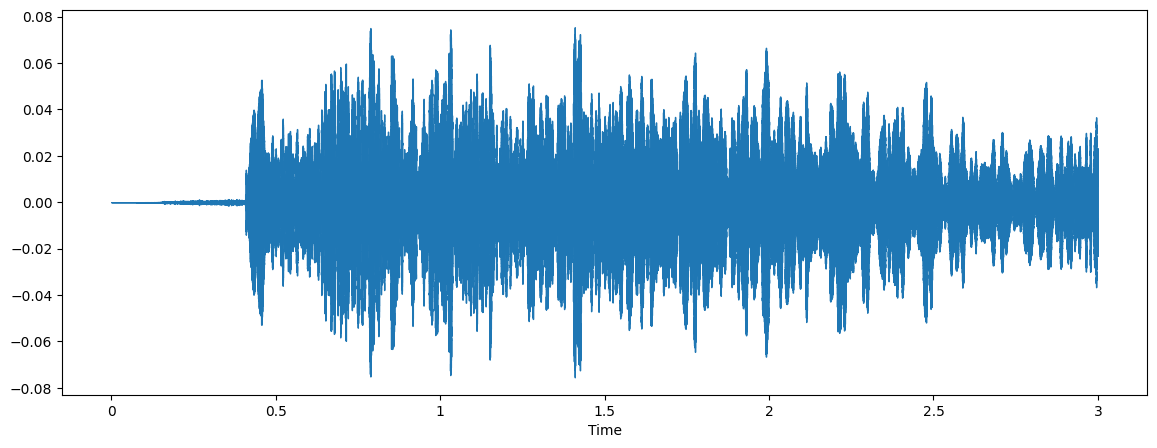

In [3]:
filename = "/content/drive/MyDrive/Vehicle Sound Classification - personal project/Ambulance.wav"
plt.figure(figsize = (14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr = sample_rate)
ipd.Audio(filename)

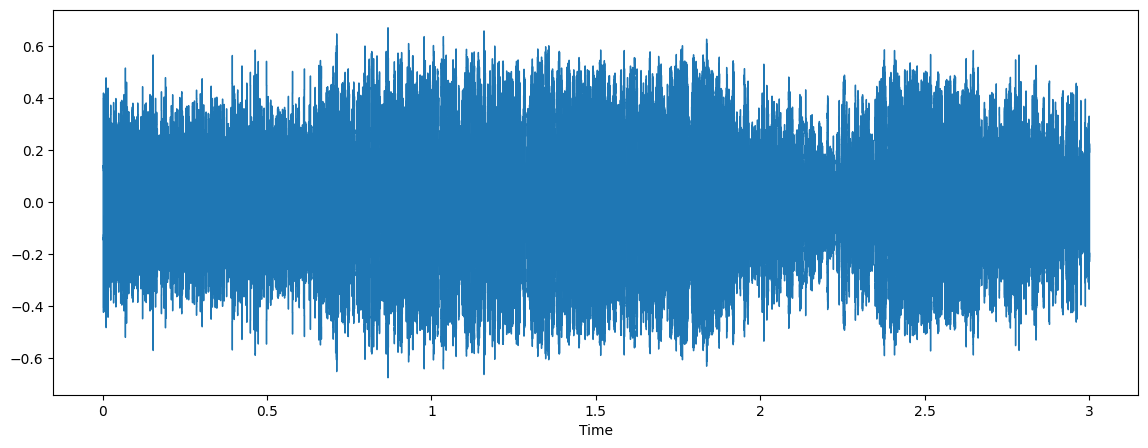

In [4]:
filename = "/content/drive/MyDrive/Vehicle Sound Classification - personal project/Firetruck.wav"
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(filename)

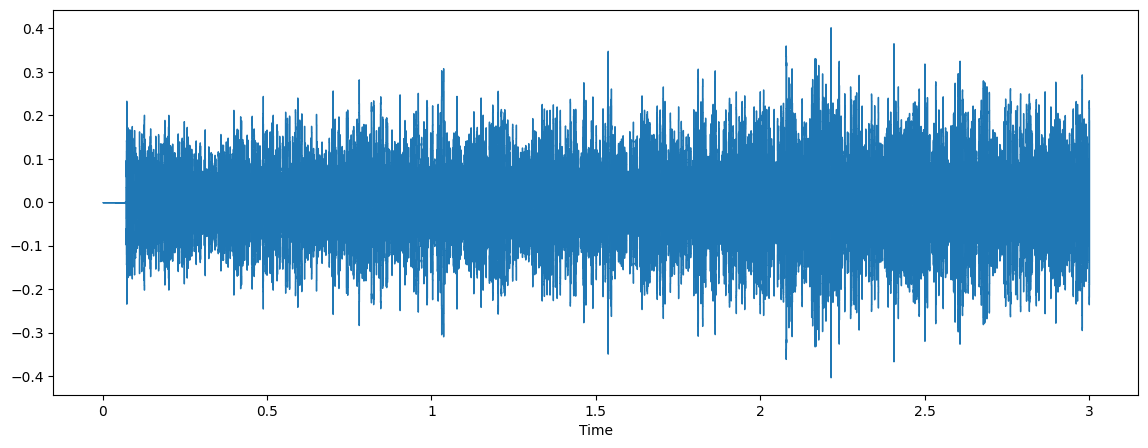

In [5]:
filename = "/content/drive/MyDrive/Vehicle Sound Classification - personal project/Traffic.wav"
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(filename)

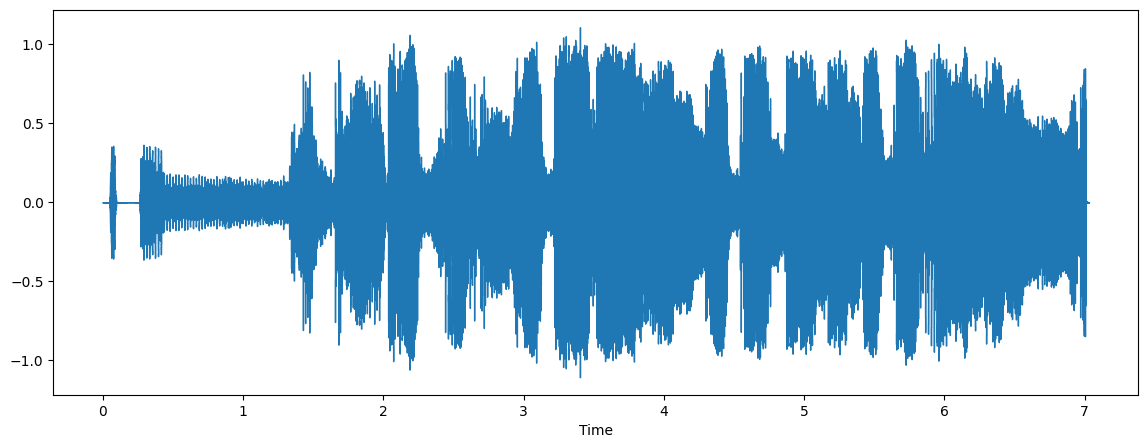

In [6]:
filename = "/content/drive/MyDrive/Vehicle Sound Classification - personal project/Engine_revving.wav"
plt.figure(figsize=(14,5))
data, sample_rate = librosa.load(filename)
librosa.display.waveshow(data, sr=sample_rate)
ipd.Audio(filename)

# **Obtaining MFCCs(Mel-Frequency Cepstral Coefficients)**

1. Divide audio into short frames (e.g., 20–40 ms).

2. Apply Fourier Transform to get the frequency spectrum of each frame.

3. Map spectrum onto the Mel scale (a scale based on how humans hear pitch).

4. Take log of energies in Mel bands (to simulate human loudness perception).

5. Apply Discrete Cosine Transform (DCT) to decorrelate and get final MFCCs.

The result is a 2D array:

1. Rows = different MFCC coefficients (e.g., 13)

2. Columns = time frames

In [7]:
!pip install resampy

In [8]:
import resampy

In [9]:
audio_dataset_path = '/content/drive/MyDrive/Vehicle Sound Classification - personal project/'

def extract_mfcc_frames(filename, n_mfcc=40, frame_ms=25, hop_ms=10):
    audio, sample_rate = librosa.load(filename, res_type='kaiser_fast')
    frame_length = int(sample_rate * frame_ms / 1000)
    hop_length = int(sample_rate * hop_ms / 1000)

    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc,
                                 n_fft=frame_length, hop_length=hop_length)

    return mfccs.T  # shape: (num_frames, n_mfcc)

In [10]:
mfccs = extract_mfcc_frames("/content/drive/MyDrive/Vehicle Sound Classification - personal project/Ambulance.wav")
print(mfccs.shape)  # (num_frames, 80)


(301, 40)


In [11]:
# Extract features
extracted_features = []

for file in os.listdir(audio_dataset_path):
    if file.lower().endswith(".wav"):
        file_name = os.path.join(audio_dataset_path, file)
        label = os.path.splitext(file)[0]  # e.g., 'Ambulance' from 'Ambulance.wav'
        mfcc_frames = extract_mfcc_frames(file_name)
        for frame in mfcc_frames:
            extracted_features.append([frame, label])



In [12]:
f = open('./Extracted_features.pkl', 'wb')
pickle.dump(extracted_features, f)

In [13]:
f = open('./Extracted_features.pkl', 'rb')
Data = pickle.load(f)
f.close()

In [14]:
df = pd.DataFrame(Data,columns=['feature', 'class'])
df.head()

feature      class
0  [-898.27435, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  Ambulance
1  [-898.27435, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  Ambulance
2  [-898.27435, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  Ambulance
3  [-898.27435, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  Ambulance
4  [-898.27435, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  Ambulance

In [15]:
df['class'].value_counts()

class
Engine_revving    705
Ambulance         301
Firetruck         301
Traffic           301
Name: count, dtype: int64

Splitting Data

In [16]:
X = np.array(df['feature'].tolist())
Y = np.array(df['class'].tolist())

In [17]:
X.shape

(1608, 40)

In [18]:
Y.shape

(1608,)

Label Encoding

In [19]:
label_encoder = LabelEncoder()
y = to_categorical(label_encoder.fit_transform(Y))

In [20]:
Y[0]

np.str_('Ambulance')

In [21]:
y[0]

array([1., 0., 0., 0.])

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y, shuffle=True)

In [23]:
y_train.shape

(1286, 4)

In [24]:
X_train.shape

(1286, 40)

In [25]:
X_test.shape

(322, 40)

In [26]:
y_test.shape

(322, 4)

Building model

In [27]:
!pip install -U scikeras scikit-learn


In [28]:
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras import backend as K
from sklearn import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from datetime import datetime

# **CNN**

In [29]:
X_train_features  = X_train.reshape(len(X_train),-1,1)
X_test_features = X_test.reshape(len(X_test),-1,1)
print("Reshaped Array Size", X_train_features.shape)

Reshaped Array Size (1286, 40, 1)


In [30]:
X_train.shape

(1286, 40)

In [31]:
def cnn(optimizer="adam", activation="relu", dropout_rate=0.5):
  K.clear_session()
  inputs = Input(shape=(X_train_features.shape[1], X_train_features.shape[2]))

  #First Conv1D layer
  conv = Conv1D(3, 13, padding='same', activation=activation)(inputs)
  if dropout_rate != 0:
    conv = Dropout(dropout_rate)(conv)
  conv = MaxPooling1D(2)(conv)

  #Second Conv1D layer
  conv = Conv1D(16, 11, padding = 'same', activation=activation)(conv)
  if dropout_rate != 0 :
    conv = Dropout(dropout_rate)(conv)
  conv = MaxPooling1D(2)(conv)

  #Maxpooling 1D
  conv = GlobalMaxPool1D()(conv)

  #Dense Layer
  conv = Dense(16, activation=activation)(conv)
  outputs = Dense(y_test.shape[1], activation='softmax')(conv)

  model = Model(inputs, outputs)
  model.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['acc'])
  return model



In [32]:
model_cnn = cnn(optimizer="adam", activation="relu", dropout_rate =0)
model_cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 40, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 40, 3)          │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 16)         │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 16)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 926 (3.62 KB)

 Trainable params: 926 (3.62 KB)

 Non-trainable params: 0 (0.00 B)

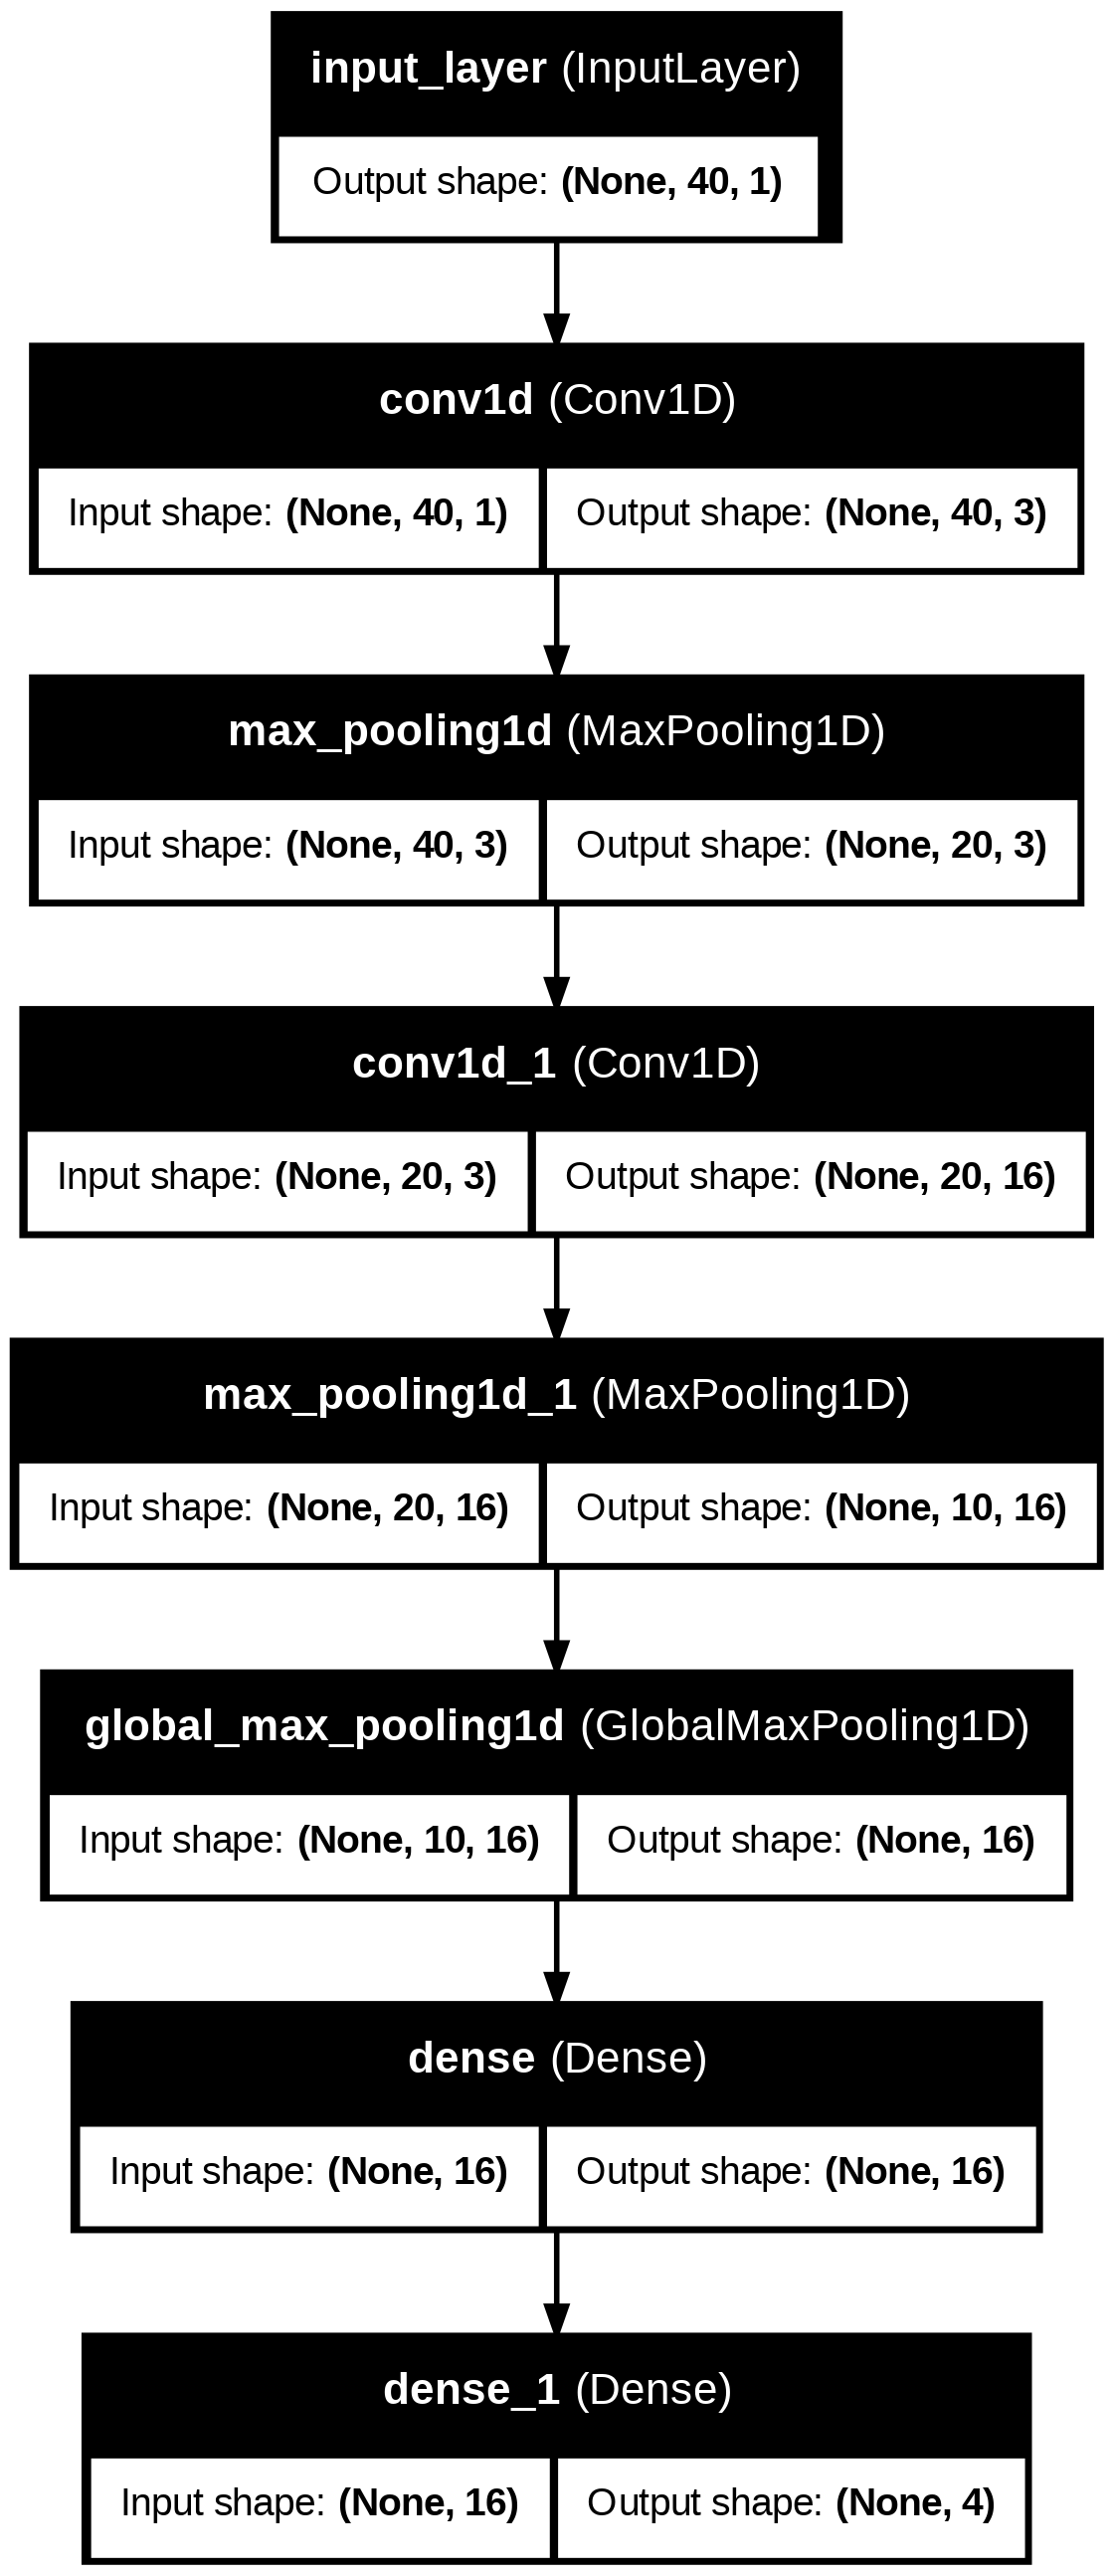

In [33]:
from tensorflow.keras.utils import plot_model

plot_model(model_cnn, show_shapes=True, show_layer_names=True)

In [34]:
early_stop = EarlyStopping(monitor = 'val_accuracy', mode ='max',
                          patience = 10, restore_best_weights = True)

history = model_cnn.fit(X_train_features, y_train, epochs = 200,
                       callbacks = [early_stop],
                       batch_size = 64, validation_data = (X_test_features, y_test))

Epoch 1/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - acc: 0.3712 - loss: 2.9353 - val_acc: 0.6118 - val_loss: 0.9341
Epoch 2/200


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: acc,loss,val_acc,val_loss
  current = self.get_monitor_value(logs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - acc: 0.6619 - loss: 0.6520 - val_acc: 0.7857 - val_loss: 0.3260
Epoch 3/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - acc: 0.8676 - loss: 0.2541 - val_acc: 0.9006 - val_loss: 0.1974
Epoch 4/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.9226 - loss: 0.1917 - val_acc: 0.9130 - val_loss: 0.1535
Epoch 5/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9454 - loss: 0.1454 - val_acc: 0.9503 - val_loss: 0.1174
Epoch 6/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9481 - loss: 0.1285 - val_acc: 0.9441 - val_loss: 0.0979
Epoch 7/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9620 - loss: 0.0928 - val_acc: 0.9503 - val_loss: 0.0849
Epoch 8/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9576 - loss: 0.0840 - val_acc: 0.9658 - val_loss: 0.0748
Epoch 9/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9664 - loss: 0.0786 - val_acc: 0.9627 - val_loss: 0.0664
Epoch 10/200
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.9580 - loss: 

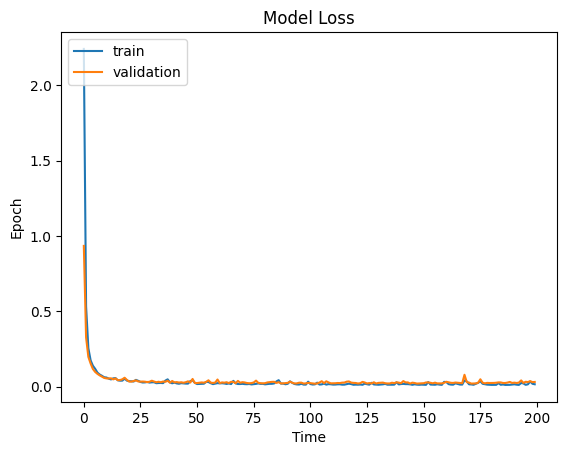

In [35]:
# Summarize History for Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Time')
plt.ylabel('Epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.show()

In [36]:
_, acc = model_cnn.evaluate(X_test_features, y_test)
print("Test Accuracy : ", acc)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9733 - loss: 0.0387     
Test Accuracy :  0.97826087474823


Predicting RMSE

In [37]:
# Predict class probabilities
y_pred_proba = model_cnn.predict(X_test_features)

# Convert one-hot to class labels
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred_proba, axis=1)

# Compute RMSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print("📉 RMSE:", rmse)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
📉 RMSE: 0.21583292365085782


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


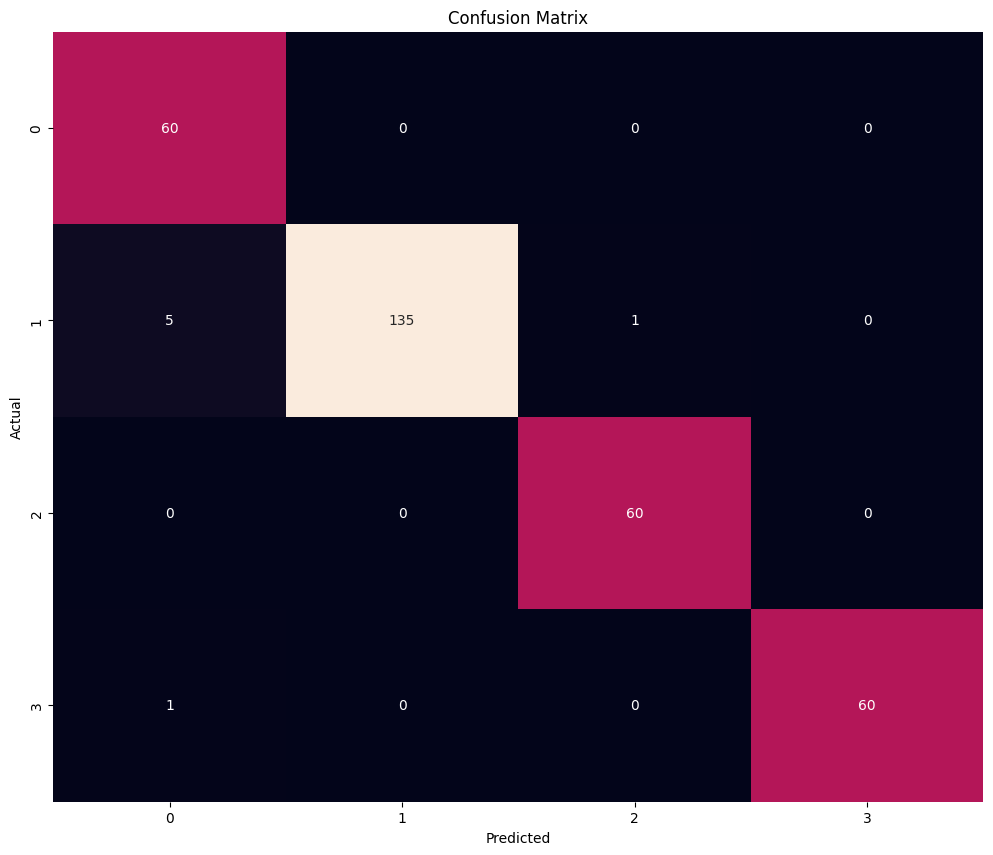

In [38]:
y_pred = model_cnn.predict(X_test_features)
from sklearn.preprocessing import LabelEncoder

# Step 1: Encode the labels
labelencoder = LabelEncoder()
y_classes = labelencoder.fit_transform(np.argmax(y_test, axis=1))  # or fit on your original y values

# Step 2: Predict with model
y_pred = model_cnn.predict(X_test_features)

# Step 3: Confusion matrix
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# Step 4: Plot
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labelencoder.classes_,
            yticklabels=labelencoder.classes_,
            cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")
plt.show()

In [39]:
model_cnn.save("cnn_model.keras")

# **LSTM**

In [40]:
x_train_features  = X_train.reshape(len(X_train),-1, 40)
x_test_features = X_test.reshape(len(X_test), -1, 40)
print("Reshaped Array Size", x_train_features.shape)

Reshaped Array Size (1286, 1, 40)


In [41]:
def lstm(x_tr):
    K.clear_session()
    inputs = Input(shape=(x_tr.shape[1], x_tr.shape[2]))
    #lstm
    x = LSTM(128)(inputs)
    x = Dropout(0.5)(x)
    #dense
    x = Dense(64, activation='relu')(x)
    x = Dense(y_test.shape[1], activation='softmax')(x)
    model = Model(inputs, x)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
    return model

In [42]:
model_lstm = lstm(x_train_features)
model_lstm.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,044 (371.27 KB)

 Trainable params: 95,044 (371.27 KB)

 Non-trainable params: 0 (0.00 B)

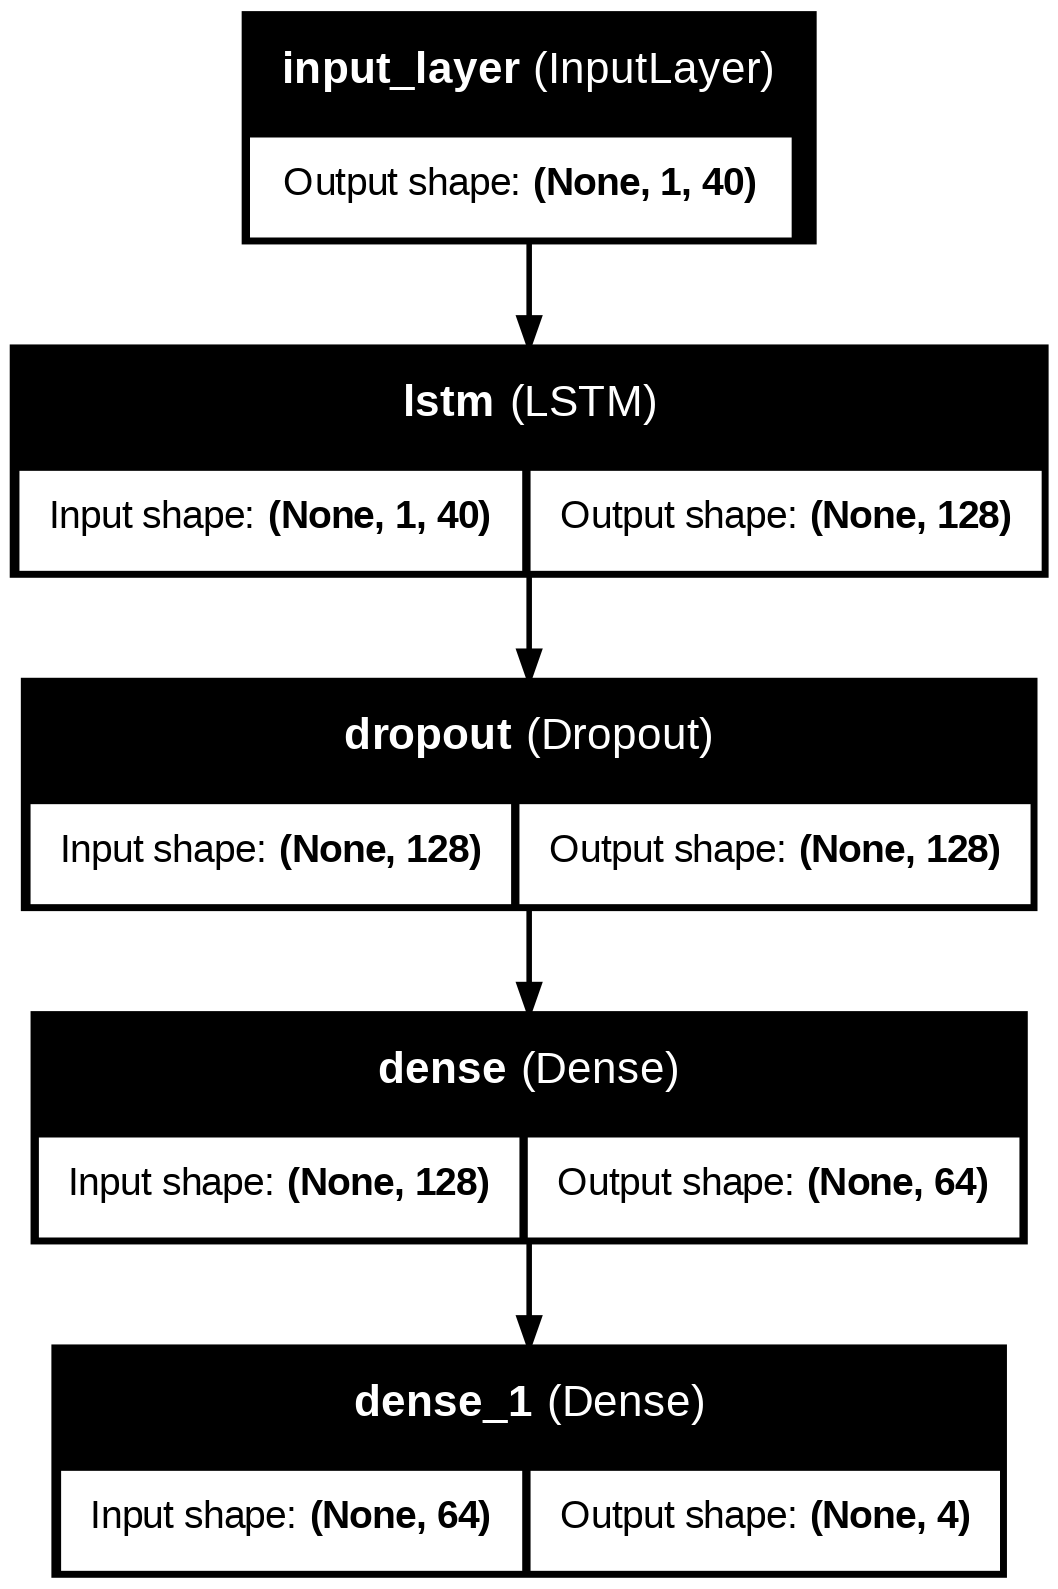

In [43]:
plot_model(model_lstm, show_shapes=True, show_layer_names=True)

In [44]:
mc = ModelCheckpoint('best_model.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [45]:
history = model_lstm.fit(x_train_features, y_train, epochs = 1000,
                        callbacks = [mc],
                        batch_size = 64, validation_data = (x_test_features, y_test))

Epoch 1/1000
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.4446 - loss: 0.5394
Epoch 1: val_acc improved from -inf to 0.86335, saving model to best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - acc: 0.4550 - loss: 0.5329 - val_acc: 0.8634 - val_loss: 0.3256
Epoch 2/1000
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.7700 - loss: 0.3273 
Epoch 2: val_acc improved from 0.86335 to 0.96894, saving model to best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.7888 - loss: 0.3141 - val_acc: 0.9689 - val_loss: 0.1760
Epoch 3/1000
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9417 - loss: 0.1923 
Epoch 3: val_acc improved from 0.96894 to 0.97826, saving model to best_model.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - acc: 0.9461 - loss: 0.1825 - val_acc: 0.9783 - val_loss: 0.0919
Epoch 4/1000
12/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9634 - loss: 0.1219 
Epoch 4: val_acc did not improve from 0.97826
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9659 - loss:

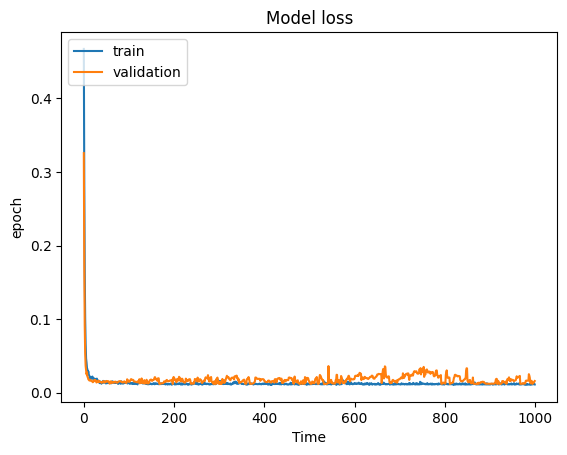

In [46]:
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Time')
plt.ylabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

In [47]:
_,acc = model_lstm.evaluate(x_test_features, y_test)
print("Accuracy:", acc)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - acc: 0.9839 - loss: 0.0186     
Accuracy: 0.9844720363616943


In [48]:
# Predict class probabilities
y_pred_proba = model_cnn.predict(X_test_features)

# Convert one-hot to class labels
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred_proba, axis=1)

# Compute RMSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print("📉 RMSE:", rmse)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
📉 RMSE: 0.21583292365085782


In [49]:
Input(shape=(X_train_features.shape[1], X_train_features.shape[2]))

<KerasTensor shape=(None, 40, 1), dtype=float32, sparse=False, name=keras_tensor_5>

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


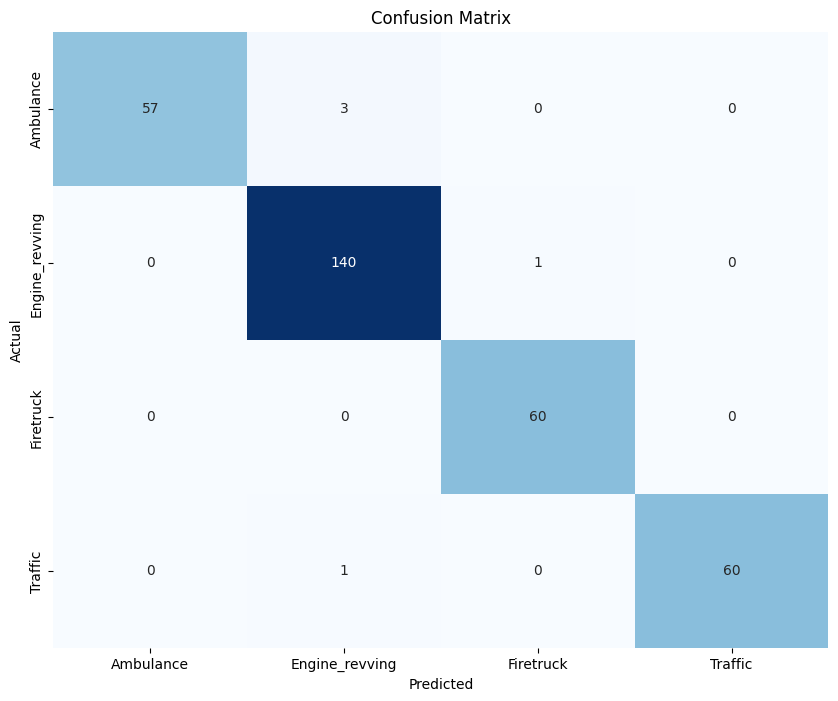

In [50]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Fit label encoder to original class names
labelencoder = LabelEncoder()
labelencoder.fit(df['class'])  # or whatever column has your raw labels

# 2. Predict
y_pred = model_lstm.predict(x_test_features)

# 3. Confusion matrix
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

# 4. Plot
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labelencoder.classes_,
            yticklabels=labelencoder.classes_,
            cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [51]:
model_lstm.save("lstm_model.keras")